
# Андан на экономе: домашнее задание 2




**ФИО:** Хачатрян Виктория Арменовна

**Твой любимый аник:** стоит полный стакан с водой, смотрит на пустой и говорит: да это же вылитый я.

***Важно прочитать перед проверкой***

я немного в шоке, так как большую часть заданий смогла сделать сама. ну как сама, я гуглила как сделать то-то, и мне выводило функцию. поэтому даже не знаю, насколько я сама все написала?

Возможно, звучит запутанно, поэтому по вопросам уточните у меня в телеге: ***kh11vika***

In [ ]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

#  Портфельная теория Марковица

В этом задании мы будем работать с данными по ценным бумагам. Мы немного поанализируем их и попробуем собрать оптимальный портфель.

- в таблице `stocks.csv` содержится информация об акциях нескольких компаний с $01.01.2014$ по $31.12.2023$ по дням.
- таблице `exchange_rates.csv` содержится информация о курсах валют _USD-RUB_, _EUR-RUB_ и _HKD-RUB_ за тот же период.

Подгрузим данные и посмотрим на них.

In [ ]:
df_stocks = pd.read_csv('https://raw.githubusercontent.com/hse-econ-data-science/andan2024/main/hw/data/stocks.csv')
print(df_stocks.shape)
df_stocks.head()

(17572, 8)


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,29.12.2023,"192,53","193,90","194,40","191,73","42,67M","-0,54%",AAPL
1,28.12.2023,"193,58","194,14","194,66","193,17","33,83M","0,22%",AAPL
2,27.12.2023,"193,15","192,49","193,50","191,09","47,90M","0,05%",AAPL
3,26.12.2023,"193,05","193,61","193,89","192,83","28,81M","-0,28%",AAPL
4,22.12.2023,"193,60","195,18","195,41","192,97","37,15M","-0,55%",AAPL


In [ ]:
df_rates = pd.read_csv('https://raw.githubusercontent.com/hse-econ-data-science/andan2024/main/hw/data/exchange_rates.csv')
print(df_rates.shape)
df_rates.head()

(3652, 4)


,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,01.01.2014,"45,189","32,855","4,237"
1,02.01.2014,"45,254","33,1","4,269"
2,03.01.2014,"45,114","33,2","4,282"
3,04.01.2014,"45,125","33,248","4,288"
4,05.01.2014,"45,228","33,255","4,289"


## 1 Причешем данные

Часто при загрузке данных из каких-либо источников, особенно если они разные, у вас будет возникать необходимость в их форматировании. Поэтому в этой части потренируемся корректировать переменные для последующей работы с ними.


__а) [2 балла]__ В колонке `'Дата'` лежат дни, в которые осуществлялась торговля акциями. Превратите её в формат `datetime` в обеих таблицах.

In [ ]:
df_stocks['Дата'] = pd.to_datetime(df_stocks.Дата, format='%d.%m.%Y') #конвертируем столбец 'Дата' из строки в формате даты и времени
df_stocks.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,2023-12-29,"192,53","193,90","194,40","191,73","42,67M","-0,54%",AAPL
1,2023-12-28,"193,58","194,14","194,66","193,17","33,83M","0,22%",AAPL
2,2023-12-27,"193,15","192,49","193,50","191,09","47,90M","0,05%",AAPL
3,2023-12-26,"193,05","193,61","193,89","192,83","28,81M","-0,28%",AAPL
4,2023-12-22,"193,60","195,18","195,41","192,97","37,15M","-0,55%",AAPL


In [ ]:
df_rates['Дата'] = pd.to_datetime(df_rates.Дата, format='%d.%m.%Y')
df_rates.head()

,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,2014-01-01,"45,189","32,855","4,237"
1,2014-01-02,"45,254","33,1","4,269"
2,2014-01-03,"45,114","33,2","4,282"
3,2014-01-04,"45,125","33,248","4,288"
4,2014-01-05,"45,228","33,255","4,289"


__б) [5 баллов]__ Для продолжения работы необходимо перевести столбцы в числовой формат, однако они содержат некорректные символы, которые не позволят сделать это напрямую.

Допишите функцию, которая примет на вход тип данных `string` и:

- Уберет лишнюю точку, разделяющую тысячные разряды в числах (например, $2.024,01 \rightarrow 2024,01$)
- Заменит символ запятой, отделяющий десятичный разряд, на точку (например, $2024,01 \rightarrow 2024.01$)
- Уберет символы `%`, `'B'` (млрд), `'M'` (млн) и `'K'` (тыс)
- Затем изменит тип данных с `string` на `float`
- И домножит на $10^9$, если в исходном значении содержалась `'B'`, на $10^6$, если `'M'`, или на $10^3$, если `'K'`.

In [ ]:
def correct_values(value):
    corrected_value = str(value).replace('.', '').replace(',', '.') #преобразуем значение в строку и заменяем символы
    if '%' in corrected_value:
        corrected_value = corrected_value.replace('%', '') #удаляем процент
    elif 'B' in corrected_value:
        corrected_value = float(corrected_value.replace('B', '')) * 10**9
    elif 'M' in corrected_value:
        corrected_value = float(corrected_value.replace('M', '')) * 10**6
    elif 'K' in corrected_value:
        corrected_value = float(corrected_value.replace('K', '')) * 10**3
    else:
        corrected_value = float(corrected_value) #преобразуем в число с плавающей точкой
    return corrected_value

columns_stocks = ['Цена', 'Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %'] # Столбцы, которые нужно преобразовать
for column in columns_stocks:
    df_stocks[column] = df_stocks[column].map(correct_values, na_action='ignore') # Применяем функцию к каждому элементу

df_stocks.head()




,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,2023-12-29,192.53,193.90,194.40,191.73,42670000.0,-0.54,AAPL
1,2023-12-28,193.58,194.14,194.66,193.17,33830000.0,0.22,AAPL
2,2023-12-27,193.15,192.49,193.50,191.09,47900000.0,0.05,AAPL
3,2023-12-26,193.05,193.61,193.89,192.83,28810000.0,-0.28,AAPL
4,2023-12-22,193.60,195.18,195.41,192.97,37150000.0,-0.55,AAPL


In [ ]:
def correct_values(value):
    corrected_value = str(value).replace('.', '').replace(',', '.') #преобразуем значение в строку и заменяем символы
    if '%' in corrected_value:
        corrected_value = corrected_value.replace('%', '') #удаляем процент
    elif 'B' in corrected_value:
        corrected_value = float(corrected_value.replace('B', '')) * 10**9
    elif 'M' in corrected_value:
        corrected_value = float(corrected_value.replace('M', '')) * 10**6
    elif 'K' in corrected_value:
        corrected_value = float(corrected_value.replace('K', '')) * 10**3
    else:
        corrected_value = float(corrected_value) #преобразуем в число с плавающей точкой
    return corrected_value

columns_rates = ['EUR_RUB', 'USD_RUB', 'HKD_RUB']  #столбцы, которые нужно преобразовать
for column in columns_rates:
    df_rates[column] = df_rates[column].map(correct_values, na_action='ignore')  #применяем функцию к каждому элементу

df_rates.head()

,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,2014-01-01,45.189,32.855,4.237
1,2014-01-02,45.254,33.100,4.269
2,2014-01-03,45.114,33.200,4.282
3,2014-01-04,45.125,33.248,4.288
4,2014-01-05,45.228,33.255,4.289


Я писала код с большим циклом for, но помню, что говорилось, что циклами лучше пользоваться по минимуму.

Я спросила Chat gpt как сделать из исходного кода фунцию (это можно было сделать самостоятельно, но у меня не вышло). Он и выдал мне этот код, но внутренность я написала сама (дада я понимаю, что это было не так сложно).

__в) [5 баллов]__ Поскольку акции компаний торгуются на разных биржах, цены также указаны в различных валютах.
Давайте приведем все к рублям, используя таблицу `df_rates`. Для этого важно знать, что данные по тикерам:

- `'AAPL'` и `'MSFT'` собраны в долларах `USD`
- `'MBGn'` и `'BMWG'` $-$ в евро `EUR`
- `'Tencent'` $-$ в Гонконгских долларах `HKD`
- по остальным $-$ в `RUB`

Давайте сначала объединим таблицы, выполнив операцию `left join` таблицы `df_stocks` с `df_rates` по столбцу `'Дата'`. Для этого будем использовать метод `merge`, [(ссылка на документацию).](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)

In [ ]:
df_merged = df_stocks.merge(df_rates, how='left', on='Дата')
df_merged.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
0,2023-12-29,192.53,193.90,194.40,191.73,42670000.0,-0.54,AAPL,98.596,90.36,11.429
1,2023-12-28,193.58,194.14,194.66,193.17,33830000.0,0.22,AAPL,97.919,89.36,11.325
2,2023-12-27,193.15,192.49,193.50,191.09,47900000.0,0.05,AAPL,101.779,91.27,11.731
3,2023-12-26,193.05,193.61,193.89,192.83,28810000.0,-0.28,AAPL,101.455,91.66,11.734
4,2023-12-22,193.60,195.18,195.41,192.97,37150000.0,-0.55,AAPL,101.467,92.00,11.791


**минутка размышллений:**  у меня вопрос. Как будет проверяться антиплагиат? Просто я, честно, не списывала пока (аххаха ключевое слово пока), но коды настолько простые, что все же их будут писать так, нет? Я просто гуглю "как сделать что-то python" и у меня отображается одна строчка

 Затем преобразуем столбцы `'Цена', 'Откр.', 'Макс.', 'Мин.'`, умножив их на соответствующий данной акции курс.

In [ ]:
stocks_currency_dict = {
    "AAPL": "USD_RUB",
    "MSFT": "USD_RUB",
    "MBGn": "EUR_RUB",
    "BMWG": "EUR_RUB",
    "Tencent": "HKD_RUB",
}

for ticker, curr_pair in stocks_currency_dict.items():
    filtered_rows = df_merged.loc[df_merged['Тикер'] == ticker] #получаем DataFrame, где 'Тикер' равен текущему тикеру
    exchange_rate = filtered_rows[curr_pair].values[0] #извлекаем обменный курс из DataFrame для данной валютной пары

    df_merged.loc[df_merged['Тикер'] == ticker, ['Цена', 'Откр.', 'Макс.', 'Мин.']] *= exchange_rate     #умножаем столбцы на обменный курс

df_merged


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
0,2023-12-29,1.571994e+06,1.583180e+06,1.587262e+06,1.565462e+06,42670000.0,-0.54,AAPL,98.596,90.360,11.429
1,2023-12-28,1.563075e+06,1.567597e+06,1.571796e+06,1.559765e+06,33830000.0,0.22,AAPL,97.919,89.360,11.325
2,2023-12-27,1.592938e+06,1.587495e+06,1.595825e+06,1.575949e+06,47900000.0,0.05,AAPL,101.779,91.270,11.731
3,2023-12-26,1.598917e+06,1.603555e+06,1.605874e+06,1.597095e+06,28810000.0,-0.28,AAPL,101.455,91.660,11.734
4,2023-12-22,1.609420e+06,1.622555e+06,1.624467e+06,1.604183e+06,37150000.0,-0.55,AAPL,101.467,92.000,11.791
...,...,...,...,...,...,...,...,...,...,...,...
17567,2014-01-08,4.760383e+03,4.788747e+03,4.798039e+03,4.744244e+03,18870000.0,1.52,Tencent,45.039,33.177,4.279
17568,2014-01-07,4.683503e+03,4.754820e+03,4.754820e+03,4.672268e+03,15020000.0,-0.32,Tencent,45.123,33.140,4.274
17569,2014-01-06,4.708540e+03,4.693365e+03,4.783434e+03,4.655184e+03,20380000.0,0.32,Tencent,45.259,33.210,4.283
17570,2014-01-03,4.692269e+03,4.749038e+03,4.792105e+03,4.681013e+03,18600000.0,-2.08,Tencent,45.114,33.200,4.282


Я писала код с **for** и **if**, и код выводился миллион лет. Я попросила chat gpt оптимизировать его.

Еше я подумала, что Вам может нужен мой исходный код (я это поняла только сейчас, поэтому код в пункте б уже не найду, чтобы добавить:

for ticker, curr_pair in stocks_currency_dict.items():
    
    for index, row in df_merged.iterrows():

        if row['Тикер'] == ticker:

            df_merged.loc[index, ['Цена', 'Откр.', 'Макс.', 'Мин.']] *= row[curr_pair]



Наконец, мы закончили с первичными преобразованиями и можем приступать к дальнейшему анализу.

## 2 Начало работы с данными

__а) [2 балла]__ Посмотрите наличие пропусков в данных таблицы `df_merged`. Информация по каким тикерам и за какой период отсутствует? Удалите строки с пропущенными данными.

In [ ]:
missing_data = df_merged.isnull().sum() #считаем пропущенные значения в каждом столбце
print(f"Пропуски:{missing_data}")

missing_tickers = df_merged[df_merged.isnull().any(axis=1)]['Тикер'].unique() #выбираем уникальныя значения тикеров с пропусками в строке
print(f"Какие тикеры отсутствуют: {missing_tickers}")

missing_periods = df_merged[df_merged.isnull().any(axis=1)]['Дата'].dt.date.unique() #выбираем уникальныя значения дат с пропусками в строке
print(f"Какой период отсутствует: {missing_periods}")

df_merged.dropna(inplace=True) #удалямм строки с пропущенными значениями
df_merged.head()

#многое взяла отсюда: https://habr.com/ru/articles/663414/

Пропуски:Дата       0
Цена       0
Откр.      0
Макс.      0
Мин.       0
Объём      9
Изм. %     0
Тикер      0
EUR_RUB    0
USD_RUB    0
HKD_RUB    0
dtype: int64
Какие тикеры отсутствуют: ['AAPL' 'BMWG' 'MBGn' 'Tencent']
Какой период отсутствует: [datetime.date(2016, 2, 27) datetime.date(2022, 11, 21)
 datetime.date(2022, 5, 3) datetime.date(2022, 5, 2)
 datetime.date(2022, 5, 4) datetime.date(2022, 4, 25)
 datetime.date(2015, 1, 17)]


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
0,2023-12-29,1.571994e+06,1.583180e+06,1.587262e+06,1.565462e+06,42670000.0,-0.54,AAPL,98.596,90.36,11.429
1,2023-12-28,1.563075e+06,1.567597e+06,1.571796e+06,1.559765e+06,33830000.0,0.22,AAPL,97.919,89.36,11.325
2,2023-12-27,1.592938e+06,1.587495e+06,1.595825e+06,1.575949e+06,47900000.0,0.05,AAPL,101.779,91.27,11.731
3,2023-12-26,1.598917e+06,1.603555e+06,1.605874e+06,1.597095e+06,28810000.0,-0.28,AAPL,101.455,91.66,11.734
4,2023-12-22,1.609420e+06,1.622555e+06,1.624467e+06,1.604183e+06,37150000.0,-0.55,AAPL,101.467,92.00,11.791


__б) [2 балла]__ Какое количество уникальных тикеров содержится в таблице `df_stocks`?

In [ ]:
unique_tickers_count = df_stocks['Тикер'].nunique() #думаю, понятно, что тут делаем
print(f"Количество уникальных тикеров в таблице df_stocks: {unique_tickers_count}")

Количество уникальных тикеров в таблице df_stocks: 7


__в) [2 балла]__  Для каких акций и в какой временной период была зафиксирована наибольшая разность между значениями `'Макс.'` и `'Мин.'` в рублях?

In [ ]:
df_merged['Разница_Макс_Мин'] = df_merged['Макс.'] - df_merged['Мин.'] #новый столбец с разницей между 'Макс.' и 'Мин.' в рублях

max_diff = df_merged['Разница_Макс_Мин'].max() #максимальная разница

max_diff_rows = df_merged[df_merged['Разница_Макс_Мин'] == max_diff] #выбираем стрчку, в которой разница между макс и мини наибольшая
print(f"Наибольшая разница:{max_diff_rows}")


Наибольшая разница:            Дата          Цена         Откр.         Макс.          Мин.  \
10205 2023-07-18  2.952752e+06  2.840552e+06  3.012630e+06  2.810490e+06   

            Объём Изм. % Тикер  EUR_RUB  USD_RUB  HKD_RUB  Разница_Макс_Мин  
10205  64520000.0   3.98  MSFT  102.184     90.9   11.613      202139.74764  


__г) [2 балла]__  В какие периоды было продано/куплено акций на наибольшую сумму рублей. Какие это были акции?

__Hint__: Объем — это количество проданных/купленных акций

In [ ]:
max_volume = max(df_merged['Объём'])
print(f"Наибольший объем: {max_volume}") #находим наибольший объем сделки

max_volume_index = np.argmax(df_merged['Объём']) #находим индекс строки с наибольшим объемом сделки

row_with_max_volume = df_merged.iloc[max_volume_index] #выбираем строку с наибольшим объемом
print(row_with_max_volume)

Наибольший объем: 703270000000.0
Дата                2023-04-27 00:00:00
Цена                           0.022465
Откр.                           0.02085
Макс.                           0.02279
Мин.                           0.020815
Объём                    703270000000.0
Изм. %                             8.32
Тикер                              VTBR
EUR_RUB                          90.293
USD_RUB                          81.332
HKD_RUB                          10.395
Разница_Макс_Мин               0.001975
Name: 12780, dtype: object


__д) [5 баллов]__  В столбике `'Изм. %'` лежат изменения стоимости ценных бумаг в процентах. При этом для каждой бумаги валюта своя.

Найдите 5 дат, в которые наблюдались наибольшие средние процентные изменения стоимости акций в абсолютном выражении.

__Hint:__ От изменения акций надо взять модуль, а затем посчитать среднее по тикерам для каждой даты.

In [ ]:
df_merged['Изм. %'] = df_merged['Изм. %'].astype(float).abs() #преобразуем столбец 'Изм. %' в числовой формат и возьмем его абсолютное значение
average_changes = df_merged.groupby('Дата')['Изм. %'].mean() #группируем по дате и вычисляем среднее абсолютное значение процентных изменений для каждой даты

top_5_dates = average_changes.nlargest(5) #находим 5 дат с наибольшими средними значениями изменений
print(top_5_dates)

Дата
2022-02-24    13.081429
2016-02-29    11.840000
2020-03-24    10.795714
2020-03-12    10.615714
2022-02-21     9.128000
Name: Изм. %, dtype: float64


__е) [2 балла]__ Сохраните ответ в переменную `top_5_diff` в виде таблички:

| Дата     | Изм. % |
|----------|--------|
| 01/01/01 |   1   |
|    ...   |  ...  |
| 03/01/01 |   3   |

In [ ]:
top_5_diff = top_5_dates.reset_index()
top_5_diff

,Дата,Изм. %
0,2022-02-24,13.081429
1,2016-02-29,11.840000
2,2020-03-24,10.795714
3,2020-03-12,10.615714
4,2022-02-21,9.128000


__ё) [5 баллов]__ Далее мы будем работать только со средними ценами, поэтому имеет смысл перевести таблицу из длинного формата в широкий

Было:

| Дата     | Цена | Тикер |
|----------|------|-------|
| 01/01/01 |  10  |   A   |
| 02/01/01 |  20  |   A   |
| 03/01/01 |  30  |   A   |
|   ...    | ...  |  ...  |
| 01/01/01 |  15  |   B   |
| 02/01/01 |  30  |   B   |
| 03/01/01 |  60  |   B   |
|   ...    | ...  |  ...  |

Станет:

| Дата     | Цена A | Цена B | ... |
|----------|--------|--------|-----|
| 01/01/14 |   10   |   15   | ... |
| 02/01/14 |   20   |   30   | ... |
| 03/01/14 |   30   |   60   | ... |
|   ...    |  ...   |  ...   | ... |


Это можно сделать по-разному, например, с помощью `pivot_table` ([ссылка](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) на документацию)

In [ ]:
df = df_merged.pivot_table(index='Дата', columns='Тикер', values='Цена', aggfunc='mean')
df.head()

Тикер,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
2014-01-02,59070.591000,372744.067099,NaN,275073.877624,111142.438560,4777.556066,NaN
2014-01-03,57959.072640,373548.074097,NaN,274578.740343,110728.228320,4692.269211,NaN
2014-01-06,58306.624308,370330.954648,135.47,274613.410641,108420.912828,4708.539649,0.04846
2014-01-07,57764.491416,371709.547583,NaN,277614.312019,109030.851864,4683.502710,NaN
2014-01-08,58188.728905,375014.179856,137.33,276253.784829,107203.964227,4760.382622,0.04791


__ж) [5 баллов]__  Для всех тикеров из таблички `df` постройти картинки с динамикой цен во времени, а также нистограммы цен. Дайте ответы на вопросы:

- Распределение стоимости акций похоже на нормальное?
- Что происходило с финансовыми рынками в течение последних $10$ лет? Они росли? Они падали? Видно ли, что были кризисы?

__Ответ:__

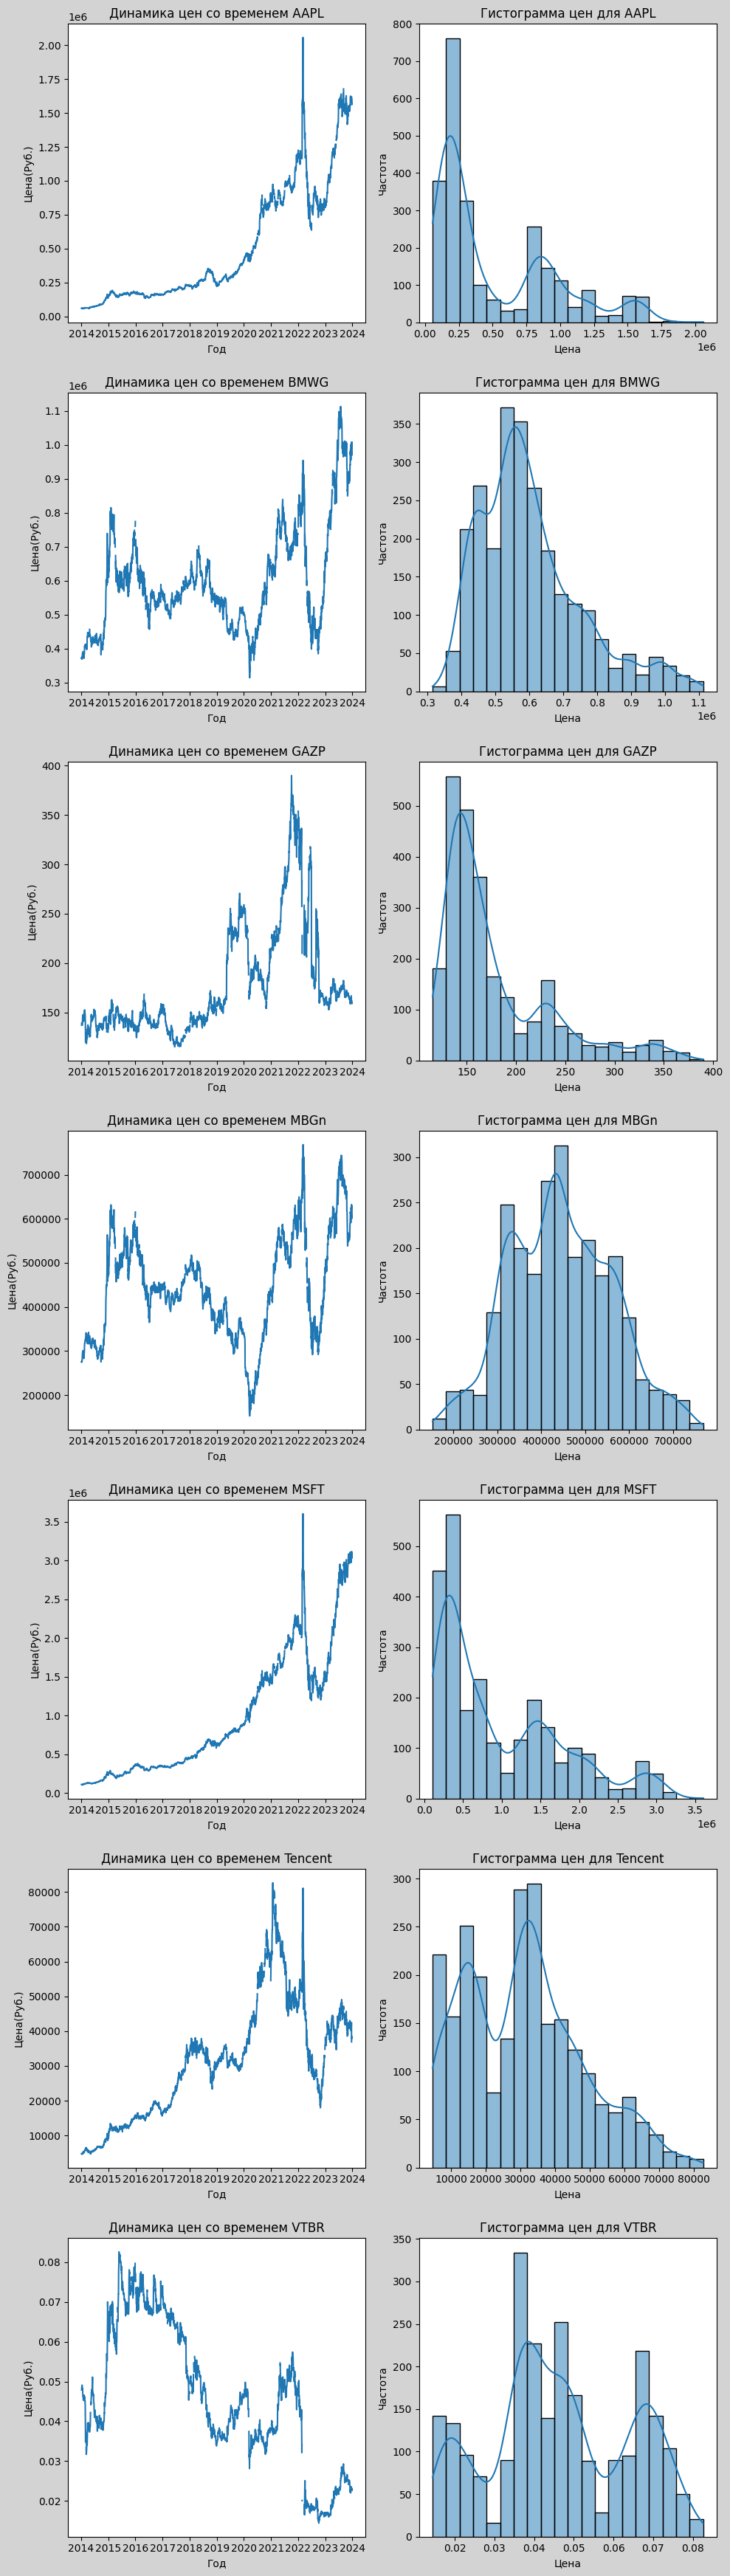

In [ ]:
fig, axs = plt.subplots(len(df.columns), 2, figsize=(10, len(df.columns) * 5), facecolor='lightgrey') #создаем фигуры и массив осей для графиков

for i, column in zip(range(len(df.columns)), df.columns):
    #график динамики цен со временем
    axs[i, 0].plot(df.index, df[column])
    axs[i, 0].set_title(f'Динамика цен со временем {column}')
    axs[i, 0].set_xlabel('Год')
    axs[i, 0].set_ylabel('Цена(Руб.)')

    #гистограмма цен
    sns.histplot(data=df, x=column, bins=20, kde=True, ax=axs[i, 1])
    axs[i, 1].set_title(f'Гистограмма цен для {column}')
    axs[i, 1].set_xlabel('Цена')
    axs[i, 1].set_ylabel('Частота')


plt.tight_layout()
plt.show()




***Распределение стоимости акций похоже на нормальное?***

По графикам видно, что отдаленно схожесть есть, где-то больше, где-то меньше. Ну оно и понятно, финансовые данные редко подчиняются строгому нормальному распределению, но в целом больше да, чем нет.

***Что происходило с финансовыми рынками в течение последних  10  лет? Они росли? Они падали? Видно ли, что были кризисы?***

Опять же, где-то был рост, где-то был спад. Однозначно был кризис в 2022-2023 годах, там везде резкий спад (как удивительно).


Финансовые продукты описываются двумя характеристикам – __доходностью__ и __риском.__ Доходность – это процентное изменение стоимости за некоторый промежуток времени:

$$
R_t = \left( \frac{P_t}{P_{t-1}} - 1 \right) \cdot 100\%.
$$

Под риском обычно имеют в виду стандартное отклонение.


__з) [5 баллов]__  Рассчитайте процентное изменение цены акций в рублях ото дня ко дню для `df`. Полученную таблицу доходностей сохраните в переменную `df_pct_change`.

__Hint__: С этим поможет метод `pct_change()`, [(ссылка на документацию).](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html)

In [ ]:
df_pct_change = df.pct_change() * 100 #рассчитываем процентное изменение цен акций в рублях от дня ко дню
df_pct_change.head()

Тикер,AAPL,BMWG,GAZP,MBGn,MSFT,Tencent,VTBR
Дата,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,-1.881678,0.215699,NaN,-0.180002,-0.372684,-1.785157,NaN
2014-01-06,0.599650,-0.861233,NaN,0.012627,-2.083764,0.346750,NaN
2014-01-07,-0.929796,0.372260,0.000000,1.092773,0.562566,-0.531735,0.000000
2014-01-08,0.734426,0.889036,1.372998,-0.490078,-1.675569,1.641505,-1.134957


__и) [5 баллов]__  Для всех тикеров из таблички `df_pct_change` постройти картинки с динамикой доходностей, гистограмму доходностей и ящики с усами. Ответьте на следующие вопроcы:

- Имеют ли доходности по акциям нормальное распределение?
- Видно ли по ящику с усами, что в данных довольно много выбросов?

__Ответ:__ ваш текст

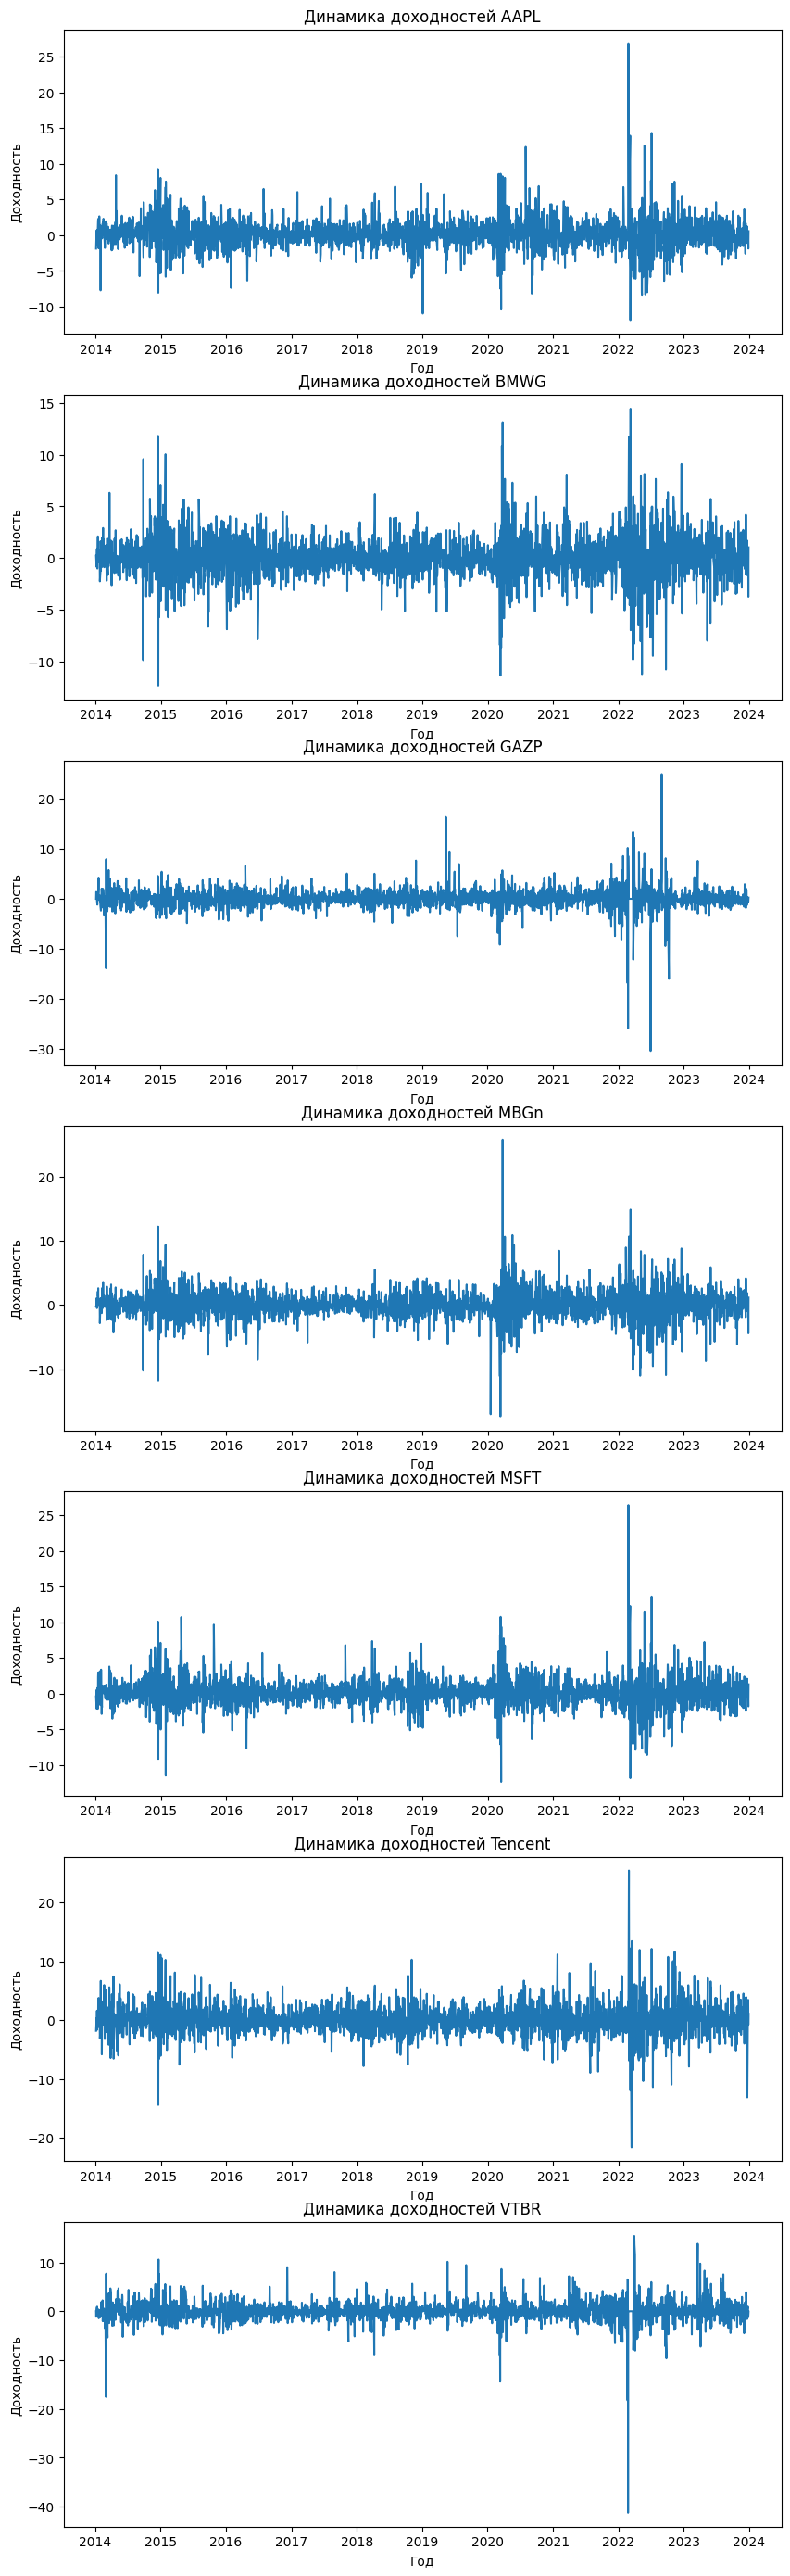

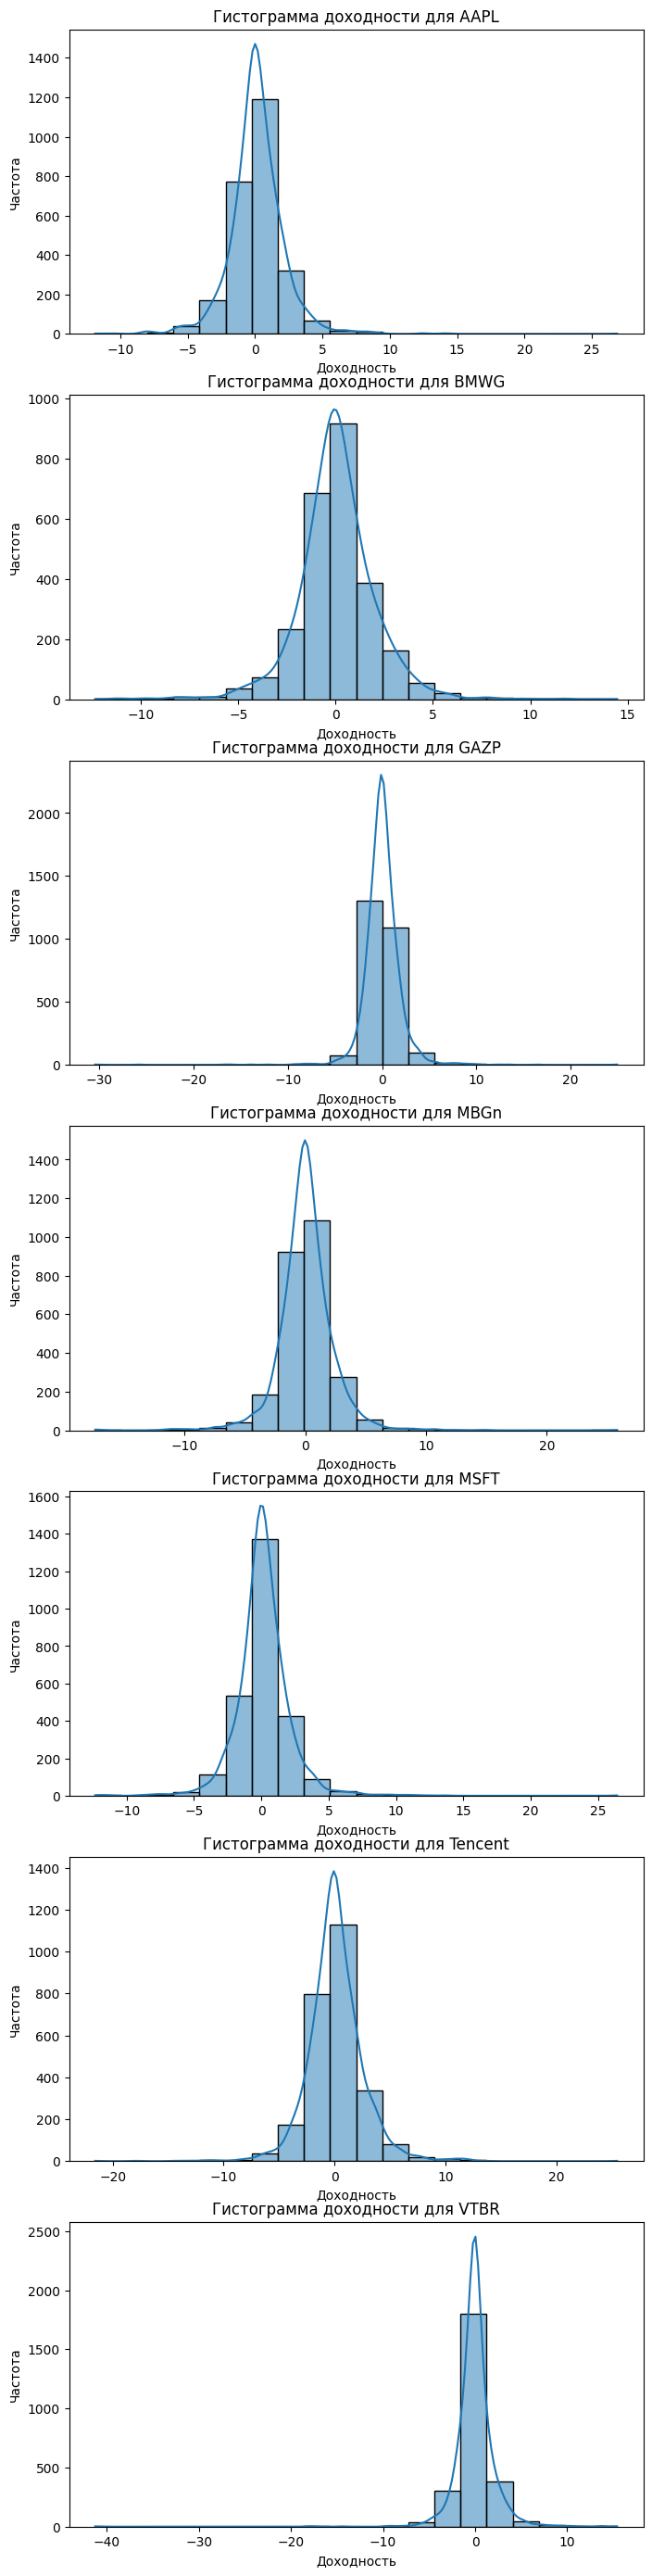

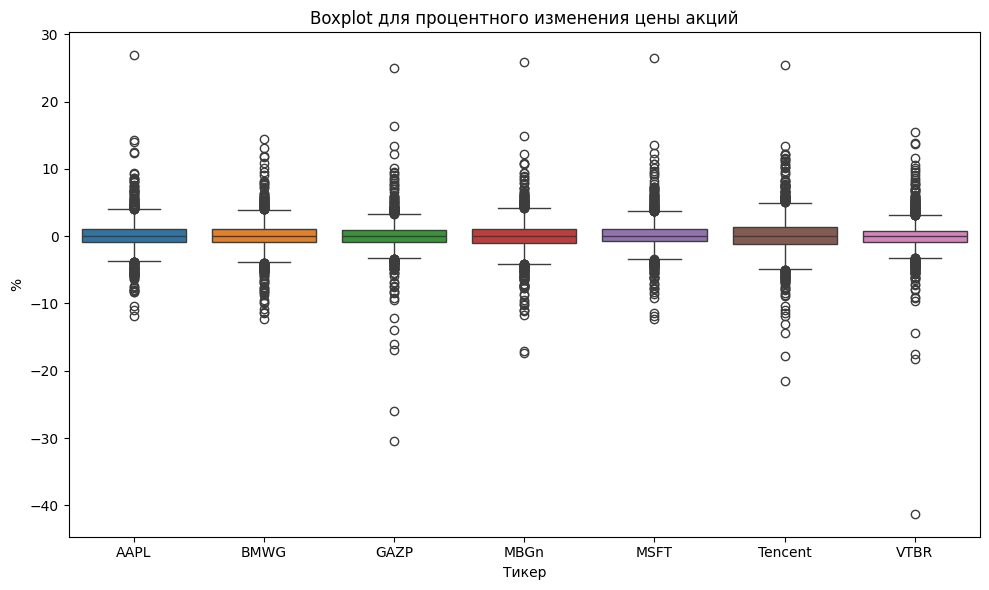

In [ ]:
fig_dyn, axs_dyn = plt.subplots(len(df_pct_change.columns), 1, figsize=(10, 5 * len(df_pct_change.columns)))
fig_hist, axs_hist = plt.subplots(len(df_pct_change.columns), 1, figsize=(8, 5 * len(df_pct_change.columns)))
fig_box, axs_box = plt.subplots(figsize=(10, 6))

#графики динамики доходностей
for i in range(len(df_pct_change.columns)):
    column = df_pct_change.columns[i]
    axs_dyn[i].plot(df_pct_change.index, df_pct_change[column])
    axs_dyn[i].set_xlabel('Год')
    axs_dyn[i].set_ylabel('Доходность')
    axs_dyn[i].set_title(f'Динамика доходностей {column}')

#гистограммы доходностей
for i in range(len(df_pct_change.columns)):
    column = df_pct_change.columns[i]
    sns.histplot(data=df_pct_change, x=column, bins=20, kde=True, ax=axs_hist[i])
    axs_hist[i].set_title(f'Гистограмма доходности для {column}')
    axs_hist[i].set_xlabel('Доходность')
    axs_hist[i].set_ylabel('Частота')

#ящик с усами для доходностей
sns.boxplot(data=df_pct_change, ax=axs_box)
axs_box.set_title('Boxplot для процентного изменения цены акций')
axs_box.set_ylabel('%')

plt.tight_layout()
plt.show()


***Имеют ли доходности по акциям нормальное распределение?***

Да

***Видно ли по ящику с усами, что в данных довольно много выбросов?***

Вроде бы скорее да, чем нет. Усы ящика довольно длинные, а медиана иногда находится далеко от верхнего или нижнего края усов, что как раз указывает на наличие выбросов.

__к) [5 баллов]__  В пункте __д)__ мы нашли даты, в которые наблюдались наибольшие измения стоимости ценых бумаг. При расчётах мы проигнорировали колебания курсов валют.

Давайте посмотрим, каким бы было колебание цен акций в абсолютном выражении для дат из таблички `top_5_diff`, если бы мы учли изменения курсов валют.

В таблице `df_pct_change` все доходности измерены в рублях. Посчитайте для этой таблицы построчное среднее для абсолютных значений изменений.

Оставьте только те даты, которые встречаются в `top_5_diff`, и добавить их в качестве нового столбца `'Изм. (RUB) %'`

__Hint__: Чтобы выделить список необходимых дат из таблички `top_5_diff`, можно воспользоваться методом `to_list()` применительно к столбцу `'Дата'`. Такой список можно дальше использовать при обращении к строкам в `'[...]'`.

In [ ]:
df_pct_change_abs_mean = df_pct_change.abs().mean(axis=1) #посчитаем построчное среднее для абсолютных значений изменений в таблице df_pct_change
top_5_dates = top_5_diff['Дата'].tolist()
df_pct_change_abs_mean_filtered = df_pct_change_abs_mean[df_pct_change_abs_mean.index.isin(top_5_dates)] # 2оставляем только те даты, которые встречаются в таблице top_5_diff

top_5_diff['Изм. (RUB) %'] = df_pct_change_abs_mean_filtered #добавим вычисленные значения в качестве нового столбца 'Изм. (RUB) %' в таблицу top_5_diff

top_5_diff


,Дата,Изм. %,Изм. (RUB) %
0,2022-02-24,13.081429,NaN
1,2016-02-29,11.840000,NaN
2,2020-03-24,10.795714,NaN
3,2020-03-12,10.615714,NaN
4,2022-02-21,9.128000,NaN


Тут мы написали код вместе Chat gpt, но не уверена как писать подводку, так как мой изначальный код был неверным - я начала задавать ворпосы типа "что не так/как исправить" и мы пришли к уже этому коду.

вот изначалъный:

absolute_mean = df_pct_change.abs().mean(axis=1)

df_absolute_mean = pd.DataFrame({'Дата': absolute_mean.index, 'Изм. (RUB) %': absolute_mean})

df_absolute_mean_filtered = df_absolute_mean[df_absolute_mean['Дата'].isin(top_5_dates['Дата'].tolist())]

top_5_diff = top_5_dates.join(df_absolute_mean_filtered.set_index('Дата'), on='Дата')

top_5_diff

__л) [2 балла]__  Проинтерпретируете уменьшение/увеличение процентного изменения стоимости акций при пересчете по курсу в рубли.

__Ответ:__

## 3 Составляем портфель


Финансовые продукты описываются двумя характеристиками: __доходностью__ и __риском__.

Доходность — это процентное изменение стоимости за некоторый промежуток времени. Под риском, как правило, понимается стандартное отклонение доходности акций.

Однако когда речь идет о нескольких акциях в портфеле, то необходимо учитывать, как связана динамика цен на эти акции: падение доходности одной из акций может быть компенсировано ростом другой. Такой портфель будет предпочтительнее, поскольку предлагает меньшие риски для инвестора.

Осталось найти то самое сладкое сочетание активов... Для поиска оптимальных весов активов в портфеле обычно решается __задача оптимизации.__

Мы поступим проще:

- Будем рассматривать портфель, состоящий всего из 2 тикеров: `'AAPL'` и `'Tencent'`.
- Наилучшее сочетание весов будем искать неоптимальным способом, тупо перебирая различные варианты.

Пусть мы вкладываем долю нашего бюджета $w$ в первую ценную бумагу, а долю $(1 - w)$ во вторую. Тогда ожидаемая доходность порфеля составит

$$
\mathbb{E}(R) = w \cdot \mathbb{E}(R_1)  + (1 - w) \cdot \mathbb{E}(R_2).
$$

Дисперсия портфеля будет равна

$$
\text{Var}(R) = w^2 \cdot \text{Var}(R_1)  + (1 - w)^2 \cdot \text{Var}(R_2) + 2 \cdot w \cdot \text{Cov}(R_1, R_2).
$$

Ковариацию, по её определению, можно переписать как

$$
\text{Cov}(R_1, R_2) = \text{Corr}(R_1, R_2) \cdot \sigma(R_1) \cdot \sigma(R_2),
$$

где $\sigma(R_i) = \sqrt{ \text{Var}(R_i)}$.


Для начала создадим веса, которые будем рассматривать.

__а) [2 балла]__ С помощью функции `np.arange()` создайте `array` от $0$ до $1$ с шагом $0.01$ [(ссылка на документацию).](https://numpy.org/doc/stable/reference/generated/numpy.arange.html)

In [ ]:
w = np.arange(0,1,0.01)

Теперь запишем необходимые характеристики акций в соответствующие переменные:

__б) [3 балла]__ В переменные `r1` и `r2` сохраните среднюю доходность акций `'AAPL'` и `'Tencent'` из `df_pct_change`. Убедитесь, что доходности представлены не в процентах, а в виде чисел. Например не $10\%$, а $0.1$.

Кроме того, поскольку стандартной мерой доходности является годовая доходность, преобразуем среднюю ежедневную доходность в годовую, используя формулу сложного процента для полученных значений:

$$
r_{\text{год}} = (1 + r_{\text{день}})^{252} - 1,
$$

где:
- $r_{\text{год}}$ - ожидаемая годовая доходность,
- $r_{\text{день}}$ - средняя ежедневная доходность,
- $252$ - количество торговых дней в году (для большинства финансовых рынков).

In [ ]:
r1 = df_pct_change['AAPL'].mean()  #преобразовываем ежедневную доходности в годовую
r2 = df_pct_change['Tencent'].mean()
trading_days = 252
r1_god = (1 + r1) ** trading_days - 1 #тут среднюю ежедневную доходность в годовую
r2_god = (1 + r2) ** trading_days - 1

print(r1, r2)
print(r1_god, r2_god)


0.14751077909006335 0.11308938501601819
1144740336269596.0 531582116409.10565


__в) [3 балла]__ Аналогично сохраните стандартные отклонения доходности этих акций в `sd1` и `sd2`. Преобразуйте эти значения из дневных в годовые:

$$
\sigma_{\text{год}} = \sigma_{\text{день}} \times \sqrt{252}
$$

Где:
- $\sigma_{\text{год}}$ - годовая волатильность,
- $\sigma_{\text{день}}$ - ежедневная волатильность,
- $252$ - количество торговых дней в году (для большинства финансовых рынков).

Эта формула основана на предположении, что ежедневные доходности распределены независимо и одинаково. В реальности рыночные условия могут влиять на точность этого преобразования, но это общепринятый метод для оценки годовой волатильности на основе ежедневных данных.

In [ ]:
sd1_day = df_pct_change['AAPL'].std() #стандартное отклонение доходности для акций
sd2_day = df_pct_change['Tencent'].std()

sd1_year = sd1_day * np.sqrt(trading_days) #преобразуем значения из дневных в годовые
sd2_year = sd2_day * np.sqrt(trading_days)

print(f"Стандартное отклонение для AAPL (ежедневное): {sd1_day}")
print(f"Стандартное отклонение для Tencent (ежедневное): {sd2_day}")
print(f"Стандартное отклонение для AAPL (годовое): {sd1_year}")
print(f"Стандартное отклонение для Tencent (годовое): {sd2_year}")


Стандартное отклонение для AAPL (ежедневное): 2.088635335663077
Стандартное отклонение для Tencent (ежедневное): 2.5777647513749486
Стандартное отклонение для AAPL (годовое): 33.1560580659985
Стандартное отклонение для Tencent (годовое): 40.920746823398154


__в) [1 балл]__ В переменную `rho` сохраните корреляцию между акциями.

In [ ]:
rho = df_pct_change['AAPL'].corr(df_pct_change['Tencent'])
print(f"Корреляция между акциями AAPL и Tencent: {rho}")


Корреляция между акциями AAPL и Tencent: 0.2631413215824039


Теперь посчитаем доходность и волатильность портфеля, используя соответствующие формулы

In [ ]:
R_portfolio = w * r1_god + (1 - w) * r2_god #рассчитываем доходность

sigma_portfolio = np.sqrt(w**2 * sd1_year**2 + (1 - w)**2 * sd2_year**2 + 2 * w * (1 - w) * rho * sd1_year * sd2_year) #рассчитываем волатильность

print(f"Доходность портфеля: {R_portfolio}")
print(f"Волатильность портфеля: {sigma_portfolio}")

Доходность портфеля: [5.31582116e+11 1.19736697e+13 2.34157572e+13 3.48578447e+13
 4.62999323e+13 5.77420198e+13 6.91841074e+13 8.06261949e+13
 9.20682824e+13 1.03510370e+14 1.14952458e+14 1.26394545e+14
 1.37836633e+14 1.49278720e+14 1.60720808e+14 1.72162895e+14
 1.83604983e+14 1.95047070e+14 2.06489158e+14 2.17931245e+14
 2.29373333e+14 2.40815420e+14 2.52257508e+14 2.63699596e+14
 2.75141683e+14 2.86583771e+14 2.98025858e+14 3.09467946e+14
 3.20910033e+14 3.32352121e+14 3.43794208e+14 3.55236296e+14
 3.66678383e+14 3.78120471e+14 3.89562559e+14 4.01004646e+14
 4.12446734e+14 4.23888821e+14 4.35330909e+14 4.46772996e+14
 4.58215084e+14 4.69657171e+14 4.81099259e+14 4.92541346e+14
 5.03983434e+14 5.15425521e+14 5.26867609e+14 5.38309697e+14
 5.49751784e+14 5.61193872e+14 5.72635959e+14 5.84078047e+14
 5.95520134e+14 6.06962222e+14 6.18404309e+14 6.29846397e+14
 6.41288484e+14 6.52730572e+14 6.64172660e+14 6.75614747e+14
 6.87056835e+14 6.98498922e+14 7.09941010e+14 7.21383097e+14
 7.

__г) [5 баллов]__ Постройте линейный график в осях (`sd_p2`, `r_p2`)

__Hint:__ Можно сделать с помощью `plt.plot(x, y)`

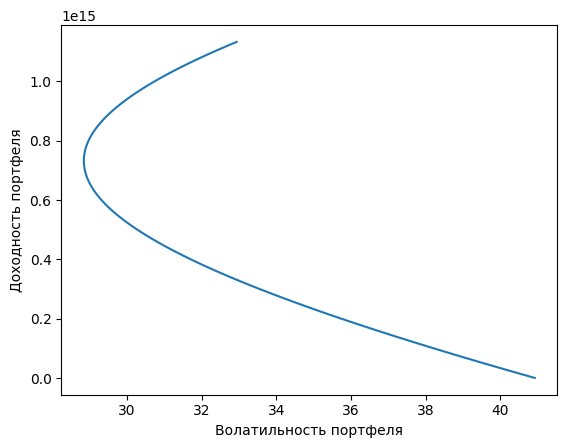

In [ ]:
plt.plot(sigma_portfolio, R_portfolio) #я просто даже не понимаю, правильно ли я поняла, 5 баллов за функцию, которую вы же нам и дали?

plt.xlabel("Волатильность портфеля")
plt.ylabel("Доходность портфеля")
plt.show()


Получившаяся у вас картинка должна быть похожа на такую:

<center>
<img src="https://investprofit.info/wp-content/uploads/2018/08/Frontier1.png" height="450">
</center>

В портфельной теории Марковица эта кривая называется эффективной границей (или кривой эффективностию). Её можно поделить на три зоны:

- **Эффективная граница (Efficient Frontier)** — это часть кривой, которая лежит выше портфеля с минимальной дисперсией (риском). Портфели на этом участке предлагают наилучшее сочетание риска и доходности. Другими словами, для любого данного уровня риска, портфели на эффективной границе предлагают максимальную возможную доходность.
- **Портфели ниже эффективной границы** считаются неэффективными, так как для того же уровня риска можно добиться большей доходности.
- **Портфели выше эффективной границы** обычно не существуют, так как они предполагали бы получение более высокой доходности при том же уровне риска.

Найдем портфель с минимальной дисперсией (риском).

__д) [3 балла]__ Для этого сначала создадим табличку со столбцами `'Вес'`, `'Риск'` и `'Доходность'` (содержащими `w`, `sd_p2` и `r_p2` соответственно)

In [ ]:
df_r = pd.DataFrame({'Вес': w, 'Риск': sigma_portfolio, 'Доходность': R_portfolio}) #опять же слишком просто, чтобы быть правдой

df_r.head()

,Вес,Риск,Доходность
0,0.00,40.920747,5.315821e+11
1,0.01,40.600047,1.197367e+13
2,0.02,40.281907,2.341576e+13
3,0.03,39.966389,3.485784e+13
4,0.04,39.653554,4.629993e+13


__е) [3 балла]__ Теперь найдем портфель с минимальным риском и запишем его в переменную `min_sd_p`, а само значение минимального риска в `min_sd`

In [ ]:
min_sd_p = df_r.loc[df_r['Риск'].idxmin()]
min_sd = min_sd_p['Риск']

min_sd_p, min_sd

(Вес           6.400000e-01
 Риск          2.884121e+01
 Доходность    7.328252e+14
 Name: 64, dtype: float64,
 28.841208268983237)

__ж) [3 балла]__ Выберем множество эффективных портфелей из `df_r`, тех, чья доходность и риск выше, чем у `min_sd_p` и сохраним их в `df_eff_p`

In [ ]:
df_eff_p = df_r[(df_r['Доходность'] > min_sd_p['Доходность']) & (df_r['Риск'] > min_sd_p['Риск'])] #выбираем эффективные портфели
df_eff_p.head()


,Вес,Риск,Доходность
65,0.65,28.845049,7.442673e+14
66,0.66,28.856028,7.557094e+14
67,0.67,28.874137,7.671514e+14
68,0.68,28.899364,7.785935e+14
69,0.69,28.931689,7.900356e+14


__з) [3 балла]__ А теперь на основе `df_eff_p` построим эффективную границу, о которой шла речь раньше (часть кривой выше портфеля с наименьшей волатильностью)

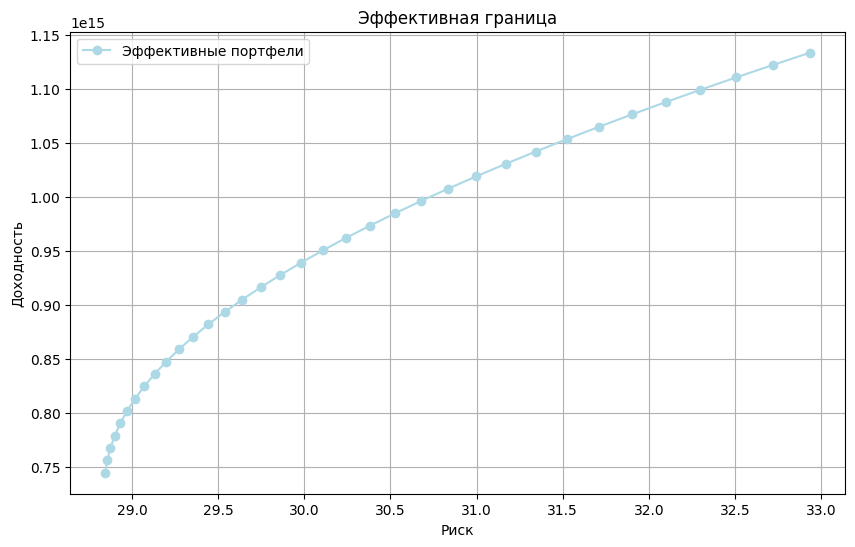

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_eff_p['Риск'], df_eff_p['Доходность'], marker='o', linestyle='-', color='lightblue', label='Эффективные портфели')
plt.xlabel('Риск')
plt.ylabel('Доходность')
plt.title('Эффективная граница')
plt.legend()
plt.grid(True)
plt.show()


Выше мы говорили, что для поиска оптимального портфеля необходимо решать задачу оптимизации. Целевую функцию для её решения можно определить по-разному. Выше мы занимались минимизацией риска и нашли `min_sd_p`.

Кроме минимизации риска можно попытаться максимизировать **коэффициент Шарпа.** Он рассчитывается по формуле

$$
SR = \frac{r_{p} - r_{f}}{\sigma_{p}},
$$

где $r_{p}$  —  ожидаемая доходность портфеля, $r_{f}$  —  безрисковая ставка доходности, $\sigma_{p}$ — стандартное отклонение доходности портфеля.

Коэффициент Шарпа отражает премию за принятый риск. Любая инвестиционная стратегия, демонстрирующая более крутой наклон кривой Шарпа, предлагает более высокую ожидаемую доходность для данного уровня риска. Следовательно, более высокий коэффициент Шарпа всегда предпочтительнее, независимо от того, какой уровень риска вы готовы принять.

В качестве безрисковой ставки доходности выберем доходность российских государственных облигаций сроком 10 лет (можно посмотреть [тут](https://cbr.ru/hd_base/zcyc_params/))

In [ ]:
r_f = 11.8 / 100

__и) [3 балла]__ Теперь у нас есть возможность рассчитать коэффициент Шарпа для кадждого портфеля в `df_r`. Для этого необходимо вычесть из доходности портфеля безрисковую ставку (`r_f`) и разделить на волатильность (риск) портфеля. Сохраните полученные значения в столбец `'Sharp'` таблицы `df_r`

In [ ]:
df_r['Sharp'] = (df_r['Доходность'] - r_f) / df_r['Риск']
df_r.head()

,Вес,Риск,Доходность,Sharp
0,0.00,40.920747,5.315821e+11,1.299053e+10
1,0.01,40.600047,1.197367e+13,2.949176e+11
2,0.02,40.281907,2.341576e+13,5.812971e+11
3,0.03,39.966389,3.485784e+13,8.721790e+11
4,0.04,39.653554,4.629993e+13,1.167611e+12


__и) [3 балла]__ Определите портфель с максимальным коэффициентом Шарпа, сохраните его в переменную `max_sharp_p`, а значение самого коэффициента - в переменную `max_sharp`

In [ ]:
max_sharp_idx = df_r['Sharp'].idxmax()
max_sharp_p = df_r.loc[max_sharp_idx]
max_sharp = max_sharp_p['Sharp']

print(f"Портфель с максимальным коэффициентом Шарпа: {max_sharp_p}")
print(f"Значение коэффициента Шарпа для этого портфеля: {max_sharp}")


Портфель с максимальным коэффициентом Шарпа: Вес           9.900000e-01
Риск          3.293454e+01
Доходность    1.133298e+15
Sharp         3.441063e+13
Name: 99, dtype: float64
Значение коэффициента Шарпа для этого портфеля: 34410626099114.38


Рассмотрим прямую в осях (Риск - Доходность), выраженную формулой

$$ r = max\_sharp \cdot \sigma + r_f $$

Для того, чтобы ее провести, нам необходимо задать хотя бы 2 точки. Чтобы построенный график хорошо выглядел, рассмотрим $\sigma$, равную:

1. наименьшему значению риска портфелей на эффективной кривой (`min_sd`)
2. значению риска, соответствующего портфелю с наибольшим значением коэффициента Шарпа (из `max_sharp_p`)

__к) [3 балла]__ В переменную `sigma` сохраните `numpy.array` с двумя перечисленными выше значениями

In [ ]:
sigma = np.array([min_sd, max_sharp_p['Риск']])
sigma

array([28.84120827, 32.93454311])

__л) [3 балла]__ В переменную `r` сохраните значения доходности, находящиеся на указанной прямой, для значений риска из `sigma` (необходимо использовать формулу прямой)

In [ ]:
r = max_sharp * sigma + r_f
r

array([9.92444034e+14, 1.13329825e+15])

__м) [5 баллов]__ Теперь построим эффективную границу, что мы уже делали ранее, и проведем указанную прямую (вернее ее часть).

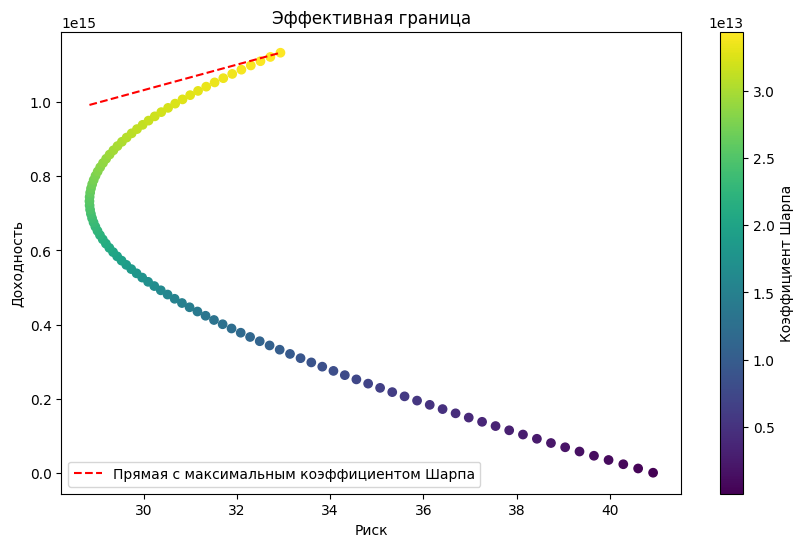

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_r['Риск'], df_r['Доходность'], c=df_r['Sharp'], cmap='viridis')
plt.title('Эффективная граница')
plt.xlabel('Риск')
plt.ylabel('Доходность')
plt.colorbar(label='Коэффициент Шарпа')

#найдем коэффициенты прямой, проходящей через точку с максимальным коэффициентом Шарпа
x_values = np.array([min(df_r['Риск']), max_sharp_p['Риск']])
y_values = max_sharp * x_values + r_f

plt.plot(x_values, y_values, linestyle='--', color='red', label='Прямая с максимальным коэффициентом Шарпа')
plt.legend()

plt.show()



Полученная прямая является касательной к эффективной кривой, а точка ее касания представляет собой так называемый тангенциальный портфель.

Каждая точка на прямой Шарпа представляет собой портфель, состоящий из комбинации безрискового актива (в нашем случае, государственных облигаций) и рыночного портфеля (здесь, сочетание двух акций).

Все портфели на прямой Шарпа считаются эффективными в смысле оптимального соотношения риска и доходности. Это означает, что для любого данного уровня риска портфель на этой линии предоставляет максимально возможную доходность.

__н) [3 балла]__ Проинтерпретируйте численное значение наибольшего коэффициента Шарпа (`max_sharp`)

Значение коэффициента Шарпа для этого портфеля, равное 34410626099114.38, является крайне высоким. Это могло бы указыватъ на то, что данный портфель обладает очень высоким уровнем доходности по отношению к риску. Но по факту, такое огромное значение коэффициента Шарпа говорит, что я где-то ошиблась, так как реальные значения коэффициента Шарпа обычно находятся в значительно более низком диапазоне.

Так что я где-то промохнулась, но не хочу больше ломать систему, поэтому примите и поймите меня.

Таким образом, мы немного углубились в портфельную теорию и рассмотрели 2 основных метода оптимизации структуры портфеля:
- поиск наименее волатильного (рискового) портфеля
- поиск портфеля с оптимальным соотношением доходности и риска.

***Спасибо большо за проверку! Надеюсь, я хотя бы подняла Вам настроение.***
